In [1]:
using ConvDiff
using PyPlot
using jInv.Mesh
using jInv.ForwardShare
using jInv.InverseSolve
using jInvVis
using jInv.LinearSolvers
using MAT

## Read problem description

We load the description of the domain, velocity, viscocity, as well as the observed data and the receiver locations from a MAT file. Note that we do not load the true model at this point. 

In [2]:
# filename= "2DmodelLShaped.mat"
filename= "Sources3D.mat"
file = matread(filename)

# problem description
domain = file["domain"]
v      = file["v"]
sig    = file["sig"]

# data and receiver location
dtrue  = file["dtrue"]
rec    = file["rec"];

# dobs = dobs + .1*randn(size(dobs))


# Setup Forward Problem

To set up the forward problem, we need to pick a mesh to dirscretize the PDE operators, a discretization method (here FEM) and we also need to discretize the measurement matrix. Since the receiver locations are, generally, at off-grid points we build a bi-linear interpolation matrix that estimates the PDE solution at those locations. 

In [11]:
Mfine = getRegularMesh(domain,vec(file["m"]));
M = getRegularMesh(domain,[96 48 48]);

x1c,x2c,x3c = getCellCenteredAxes(Mfine)
rec3D = [kron(ones(length(x3c)),rec) kron(x3c,ones(size(rec,1)))]

# build linear interpolation matrix from nodes to receiver locations
x1,x2,x3 = getNodalAxes(M)
P = interpmat(x1,x2,x3, rec3D);


dobs = dtrue + 0.01*randn(size(dtrue))

pFor = getConvDiffFEMParam(M,v=v,sig=sig,P=P,Ainv=getMUMPSsolver());

# Setup Inverse Problem


We set up the relaxed formulation of the inverse problem. To this end, we need to configure the misfit function, select a regularizer, and choose some optimization paramters.

In [12]:
## configure misfit
Wt         = ones(size(dobs))/Mfine.n[3]      
sigback    = 0.0
pMis       = getMisfitParam(pFor,Wt,dobs,SSDFun) 
	
## Configure regularization
mref       = zeros(M.nc)           
alpha      = 1e-2
reg        = (m,mr,M,I=1.0) -> anisoTVReg(m,mr,M,eps=1e-8)  
# reg        = (m,mr,M,I=1.0) -> wTVReg(m,mr,M,eps=1e-8)  
	
## Configure optimization
maxIter    = 1000
minUpdate  = 1e-3
HesPrec    = getSSORRegularizationPreconditioner(1.0,1e-15,50)
cgit       = 5 
pcgTol     = 1e-1
modFun     = identityMod
boundsLow  = 0*ones(M.nc)
boundsHigh = 1*ones(M.nc)
maxStep	   = 0.1*maximum(boundsHigh)

## store the configuration 
pInv       = getInverseParam(M,modFun,reg,alpha,mref,
                             boundsLow,boundsHigh,maxStep=maxStep,
                            pcgMaxIter=cgit,pcgTol=pcgTol,minUpdate=minUpdate,maxIter=maxIter,
                            HesPrec=HesPrec);
	


# Run Inversion

In [13]:
mc,Dc,flag,His = projGNCG(mref+0.1,pInv,pMis)
uc = pFor.Fields;          # u variables
wr = pInv.modelfun(mc)[1]; # w variables



 i.LS	       F	       R	alpha[1]	   Jc/J0	 #Active
  1.0	1.91e-02	6.77e-01	1.00e-02	1.00e+00	  0
   .1	1.49e-02	6.77e-01			9.94e-01
  2.0	1.49e-02	6.77e-01	1.00e-02	9.94e-01	  0
   .1	1.13e-02	6.76e-01			9.88e-01
  3.0	1.13e-02	6.76e-01	1.00e-02	9.88e-01	  0
   .1	8.28e-03	6.76e-01			9.83e-01
  4.0	8.28e-03	6.76e-01	1.00e-02	9.83e-01	  0
   .1	5.76e-03	6.76e-01			9.79e-01
  5.0	5.76e-03	6.76e-01	1.00e-02	9.79e-01	  0
   .1	3.77e-03	6.76e-01			9.76e-01
  6.0	3.77e-03	6.76e-01	1.00e-02	9.76e-01	  0
   .1	2.28e-03	6.76e-01			9.74e-01
  7.0	2.28e-03	6.76e-01	1.00e-02	9.74e-01	1833
   .1	1.27e-03	6.76e-01			9.73e-01
  8.0	1.27e-03	6.76e-01	1.00e-02	9.73e-01	18428
   .1	7.26e-04	6.76e-01			9.72e-01
  9.0	7.26e-04	6.76e-01	1.00e-02	9.72e-01	78130
   .1	6.67e-04	6.76e-01			9.72e-01
 10.0	6.67e-04	6.76e-01	1.00e-02	9.72e-01	108934
   .1	6.67e-04	6.76e-01			9.72e-01
 11.0	6.67e-04	6.76e-01	1.00e-02	9.72e-01	113186
   .1	6.66e-04	6.76e-01			9.72e-01
 12.0	6.66e-04	6.76e-01	1.00e-02	9.72e-01	1124

LoadError: [91mInterruptException:[39m

## Visualize Results

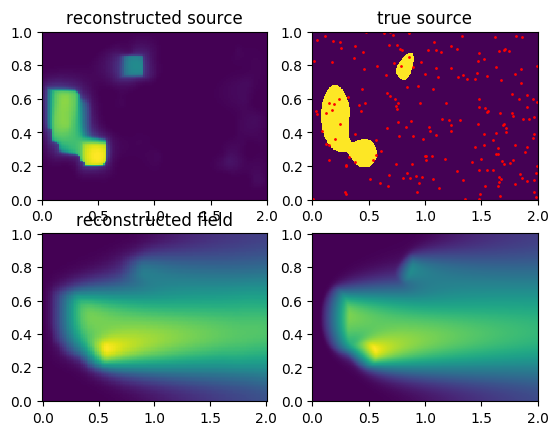

PyObject <matplotlib.collections.QuadMesh object at 0x128427050>

In [6]:
subplot(2,2,1)
viewImage2D(wr,M)
title("reconstructed source")
subplot(2,2,2)
viewImage2D(vec(file["W"]),getRegularMesh(domain,file["m"]));
plot(rec[:,1],rec[:,2],"or",MarkerSize=1)
title("true source")


subplot(2,2,3)
viewImage2D(uc,getPaddedMesh(M))
title("reconstructed field")

subplot(2,2,4)
viewImage2D(vec(file["utrue"]),getPaddedMesh(getRegularMesh(domain,file["m"])))
